In [ ]:
import pandas as pd

In [ ]:
# Check if all x values are identical before performing regression
if len(group['date_numeric'].unique()) > 1:
    slope, intercept, r_value, p_value, std_err = linregress(group['date_numeric'], group['delta_wte'])
    # Proceed with plotting the regression line
else:
    print("Skipping regression for group with identical date_numeric values.")test.head()


In [ ]:
test.info()

In [ ]:
pip install openpyxl

In [ ]:
gage_class=pd.read_excel('data/GAGES-II_ref_non_ref.xlsx')
gage_class.head()

In [ ]:
gage_class.info()

In [ ]:
gage_in_gslb=pd.read_csv('shp/gsl_nwm_gage.csv')
gage_in_gslb.head()

In [ ]:
import pandas as pd

# Check the initial assignment
print("Loading gage_class from Excel file...")
try:
    gage_class = pd.read_excel('data/GAGES-II_ref_non_ref.xlsx')
    print("Successfully loaded gage_class as DataFrame")
except Exception as e:
    print(f"Error loading gage_class: {e}")

# Check the type and value of gage_class
print(f"Type of gage_class after loading: {type(gage_class)}")
print(gage_class.head())

# Ensure gage_class is not overwritten
# Add similar checks throughout your code where gage_class is used


In [ ]:
# Ensure the necessary columns are of string type for merging
gage_class['STAID'] = gage_class['STAID'].astype(str)
gage_in_gslb['id'] = gage_in_gslb['id'].astype(str)

# Merge gage_in_gslb with gage_class to include the class information
gage_in_gslb_with_class = gage_in_gslb.merge(
    gage_class[['STAID', 'CLASS']],
    left_on='id',
    right_on='STAID',
    how='left'
)

# Drop the duplicate STAID column and rename CLASS to lowercase
gage_in_gslb_with_class = gage_in_gslb_with_class.drop('STAID', axis=1)
gage_in_gslb_with_class = gage_in_gslb_with_class.rename(columns={'CLASS': 'class'})

# Calculate the total number of gages
total_gages = len(gage_in_gslb_with_class)

# Count the number of gages in each class
class_counts = gage_in_gslb_with_class['class'].value_counts()

# Calculate the percentage of gages in each class
class_percentages = (class_counts / total_gages) * 100

# Display the results
print("Number of gages in each class:")
print(class_counts)
print("\nPercentage of gages in each class:")
print(class_percentages.round(2), "%")


In [ ]:
# Get the reference gages that are within the GSL basin
ref_gages_in_gslb = gage_in_gslb_with_class[gage_in_gslb_with_class['class'] == 'Ref']

# Display the reference gages in GSL basin with their details
ref_gages_in_gslb[['id', 'name', 'River', 'latitude', 'longitude', 'state', 'class']]

# 画散点图，并计算统计

## scatter plots q vs delta wte

In [ ]:
final_result_cleaned = pd.read_csv('base_on_bfd_1/q_buffer2_pair_delta.csv')

In [ ]:
final_result_cleaned.head()

In [ ]:
# Convert gage_id in both dataframes to string for merging
final_result_cleaned['gage_id'] = final_result_cleaned['gage_id'].astype(str)
gage_class['STAID'] = gage_class['STAID'].astype(str)

# Merge final_result_cleaned with gage_class to add CLASS column
final_result_cleaned = final_result_cleaned.merge(
    gage_class[['STAID', 'CLASS']],
    left_on='gage_id',
    right_on='STAID',
    how='left'
)

# Drop redundant STAID column and rename CLASS to lowercase
final_result_cleaned.drop('STAID', axis=1, inplace=True)
final_result_cleaned.rename(columns={'CLASS': 'class'}, inplace=True)


In [ ]:
final_result_cleaned.head()

In [ ]:
# Count the number of Non-ref and Ref gages
gage_counts = final_result_cleaned['class'].value_counts()

# Display the counts
print("Number of Non-ref gages:", gage_counts.get('Non-ref', 0))
print("Number of Ref gages:", gage_counts.get('Ref', 0))


In [ ]:
final_result_cleaned.head()

In [ ]:
final_result_cleaned.info()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.dates as mdates
import os
from matplotlib.patches import Patch

# Ensure the plots directory exists
os.makedirs('base_on_bfd_1/scatter_plots_q_delta_wte', exist_ok=True)

# Prepare a list to collect statistical data for CSV
stats_data = []

# Group by gage_id
grouped = final_result_cleaned.groupby('gage_id')

# Iterate over each group
for gage_id, group in grouped:
    group = group.dropna(subset=['delta_wte', 'q'])
    group['date'] = pd.to_datetime(group['date'])

    plt.figure(figsize=(12, 6))

    # Plot: different wells as different colors
    sns.scatterplot(
        data=group,
        x='delta_wte',
        y='q',
        hue='well_id',
        palette='viridis',
        edgecolor='none',
        legend=False  # suppress seaborn legend (we use our own)
    )

    legend_text = ""

    if len(group) >= 2:
        if len(group['delta_wte'].unique()) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(
                group['delta_wte'], group['q']
            )

            delta_wte_range = pd.Series(group['delta_wte'].unique()).sort_values()
            plt.plot(delta_wte_range, intercept + slope * delta_wte_range, 'r', linewidth=2)

            stats_data.append({
                'gage_id': gage_id,
                'num_wells': group['well_id'].nunique(),
                'num_measurements': len(group),
                'slope': slope,
                'intercept': intercept,
                'r_squared': r_value ** 2,
                'p_value': p_value,
                'class': group['class'].iloc[0]
            })

            legend_text = (
                f"Wells: {group['well_id'].nunique()}\n"
                f"Measurements: {len(group)}\n"
                f"Slope: {slope:.2f}\n"
                f"R²: {r_value ** 2:.2f}\n"
                f"p-value: {p_value:.4f}"
            )
        else:
            legend_text = (
                f"Wells: {group['well_id'].nunique()}\n"
                f"Measurements: {len(group)}\n"
                "All delta_wte values identical\nNo regression line"
            )
    else:
        legend_text = (
            f"Wells: {group['well_id'].nunique()}\n"
            f"Measurements: {len(group)}\n"
            "Not enough data"
        )

    # Title and labels
    plt.title(f'Gage ID: {gage_id} - Class: {group["class"].iloc[0]}')
    plt.xlabel('Delta WTE (ft)')
    plt.ylabel('Q')

    # Grid and background
    plt.gca().yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.gca().xaxis.grid(False)
    plt.gca().set_facecolor('white')

    # Add transparent text box as a replacement for legend
    plt.text(
        0.98, 0.95,
        legend_text,
        transform=plt.gca().transAxes,
        fontsize=10,
        ha='right',
        va='top',
        linespacing=1.4,
        bbox=dict(
            facecolor='white',
            edgecolor='black',
            alpha=0.75,
            boxstyle='square,pad=0.4'
        )
    )

    # Save the figure
    plt.savefig(f'base_on_bfd_1/scatter_plots_q_delta_wte/gage_{gage_id}.png', bbox_inches='tight')
    plt.close()

# Export statistics
stats_df = pd.DataFrame(stats_data)
stats_df.to_csv('base_on_bfd_1/scatter_q_delta_wte_statistics.csv', index=False)


In [ ]:
stats_df = pd.read_csv('base_on_bfd_1/scatter_q_delta_wte_statistics.csv')

In [ ]:
# Filter the DataFrame for Non-ref and ref gages
non_ref_gages = stats_df[stats_df['class'] == 'Non-ref']
ref_gages = stats_df[stats_df['class'] == 'Ref']

# Count the number of Non-ref and ref gages
num_non_ref_gages = non_ref_gages['gage_id'].nunique()
num_ref_gages = ref_gages['gage_id'].nunique()

# Calculate the percentage of positive slopes for Non-ref and ref gages
positive_slope_percentage_non_ref = (non_ref_gages['slope'] > 0).mean() * 100
positive_slope_percentage_ref = (ref_gages['slope'] > 0).mean() * 100

# Print the results
print(f"Number of Non-ref gages: {num_non_ref_gages}")
print(f"Number of ref gages: {num_ref_gages}")
print(f"Percentage of Non-ref gages with a positive slope: {positive_slope_percentage_non_ref:.2f}%")
print(f"Percentage of ref gages with a positive slope: {positive_slope_percentage_ref:.2f}%")


## delta wte time series

In [ ]:
final_result_cleaned.head()

#### two plots. q delta wte time series

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

# Ensure the plots directory exists
os.makedirs('base_on_bfd_1/subplot_q_delta_wte_time', exist_ok=True)

# Prepare a list to collect statistical data for CSV
stats_data = []

# Assuming final_result_cleaned is already loaded as a DataFrame
# Group by gage_id
grouped = final_result_cleaned.groupby('gage_id')

# Iterate over each group
for gage_id, group in grouped:
    # Drop NaN values
    group = group.dropna(subset=['delta_wte', 'date', 'q'])

    # Convert date to datetime format
    group['date'] = pd.to_datetime(group['date'])

    # Sort by date to ensure the line plot is correct
    group = group.sort_values('date')

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot q vs. date on the top subplot
    ax1.scatter(group['date'], group['q'], color='orange', label='Q (cfs)', alpha=0.6)

    # Perform linear regression for q
    if len(group) > 1 and len(group['date'].unique()) > 1:
        group['date_numeric'] = group['date'].map(pd.Timestamp.toordinal)
        slope_q, intercept_q, r_value_q, p_value_q, std_err_q = linregress(group['date_numeric'], group['q'])

        # Plot the regression line for q
        ax1.plot(group['date'], intercept_q + slope_q * group['date_numeric'], 'r', label='Fitted line for Q')

        # Prepare legend text for q
        legend_text_q = (
            f"Q Points: {len(group)}\n"
            f"Slope Q: {slope_q:.6f}\n"
            f"R² Q: {r_value_q ** 2:.2f}\n"
            f"P-value Q: {p_value_q:.4f}"
        )
    else:
        legend_text_q = (
            f"Q Points: {len(group)}\n"
        )

    ax1.set_ylabel('Q (cfs)')
    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Add a custom legend with statistical data for q
    ax1.text(
        0.05, 0.95,
        legend_text_q,
        transform=ax1.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
    )

    # Plot delta_wte vs. date on the bottom subplot
    ax2.scatter(group['date'], group['delta_wte'], color='blue', label='Delta WTE', alpha=0.6)

    # Perform linear regression for delta_wte
    if len(group) > 1 and len(group['date'].unique()) > 1:
        slope_wte, intercept_wte, r_value_wte, p_value_wte, std_err_wte = linregress(group['date_numeric'], group['delta_wte'])

        # Plot the regression line for delta_wte
        ax2.plot(group['date'], intercept_wte + slope_wte * group['date_numeric'], 'r', label='Fitted line for Delta WTE')

        # Collect statistics
        stats_data.append({
            'gage_id': gage_id,
            'num_wells': group['well_id'].nunique(),
            'num_measurements': len(group),
            'slope_q': slope_q,
            'r_squared_q': r_value_q ** 2,
            'p_value_q': p_value_q,
            'slope_wte': slope_wte,
            'r_squared_wte': r_value_wte ** 2,
            'p_value_wte': p_value_wte
        })

        # Prepare legend text for delta_wte
        legend_text_wte = (
            f"Wells: {group['well_id'].nunique()}\n"
            f"Measurements: {len(group)}\n"
            f"Slope WTE: {slope_wte:.6f}\n"
            f"R² WTE: {r_value_wte ** 2:.2f}\n"
            f"P-value WTE: {p_value_wte:.4f}"
        )
    else:
        legend_text_wte = (
            f"Wells: {group['well_id'].nunique()}\n"
            f"Measurements: {len(group)}\n"
        )

    ax2.set_ylabel('Delta WTE (ft)')
    ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Add a custom legend with statistical data for delta_wte
    ax2.text(
        0.05, 0.95,
        legend_text_wte,
        transform=ax2.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
    )

    # Set a single title for both subplots, closer to the plots
    fig.suptitle(f'Gage ID: {gage_id} - Q and Delta WTE vs. Time', fontsize=16, y=0.92)

    # Format the date axis
    ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())  # Automatically adjust date ticks
    plt.xticks(rotation=45)

    # Save the plot
    plt.savefig(f'base_on_bfd_1/subplot_q_delta_wte_time/gage_{gage_id}.png', bbox_inches='tight')
    plt.close()

# Export statistics to CSV
stats_df = pd.DataFrame(stats_data)
stats_df.to_csv('base_on_bfd_1/delta_wte_statistics.csv', index=False)

# Calculate the percentage of positive slopes for both q and delta_wte
positive_slope_percentage_q = (stats_df['slope_q'] > 0).mean() * 100
positive_slope_percentage_wte = (stats_df['slope_wte'] > 0).mean() * 100

# Print the results
print(f"Percentage of gages with a positive slope for Q: {positive_slope_percentage_q:.2f}%")
print(f"Percentage of gages with a positive slope for Delta WTE: {positive_slope_percentage_wte:.2f}%")


## 对entire basin

### total delta q vs delta wte

In [ ]:
final_result_cleaned = final_result_cleaned.copy()

In [ ]:
# Remove the rows with the smallest two delta_wte values
final_result_cleaned = final_result_cleaned.sort_values(by='delta_wte')
final_result_cleaned = final_result_cleaned.iloc[2:]  # Skip the first two rows

# Remove the row with the largest delta_q value
final_result_cleaned = final_result_cleaned.sort_values(by='delta_q', ascending=False)
final_result_cleaned = final_result_cleaned.iloc[1:]  # Skip the first row

# Reset the index if needed
final_result_cleaned.reset_index(drop=True, inplace=True)

# Print the resulting DataFrame
print(final_result_cleaned)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Convert delta_q to acre-ft/year if not already done
final_result_cleaned['delta_q_acre_ft_year'] = final_result_cleaned['delta_q'] * 365.25

# Plot all delta_q vs all delta_wte
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='delta_wte',
    y='delta_q_acre_ft_year',
    data=final_result_cleaned,
    alpha=0.5
)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(
    final_result_cleaned['delta_wte'], final_result_cleaned['delta_q_acre_ft_year']
)

# Plot the regression line
sns.regplot(
    x='delta_wte',
    y='delta_q_acre_ft_year',
    data=final_result_cleaned,
    scatter=False,
    color='red'
)

# Add statistical data to the plot
plt.title('Delta Q (acre-ft/year) vs Delta WTE')
plt.xlabel('Delta WTE (ft)')
plt.ylabel('Delta Q (acre-ft/year)')
plt.grid(True)
plt.text(
    0.05, 0.95,
    f'Slope: {slope:.2f}\nR²: {r_value**2:.2f}\nP-value: {p_value:.4f}',
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

plt.show()


In [ ]:
final_result_cleaned = pd.read_csv('base_on_bfd_1/q_buffer2_pair_delta.csv')

In [ ]:
# Sort the DataFrame by delta_wte in ascending order
sorted_by_delta_wte = final_result_cleaned.sort_values(by='delta_wte')

# Print the sorted DataFrame
print(sorted_by_delta_wte)


### normalized delta q vs delta wte

In [99]:
final_result_cleaned = pd.read_csv('base_on_bfd_1/q_buffer2_pair_delta.csv')

In [ ]:
df = final_result_cleaned.copy()

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
print((df['normalized_delta_q'] < 0).sum())


In [85]:
# 总列数
total_count = len(df['normalized_delta_q'])

# 负数部分的数量
negative_count = (df['normalized_delta_q'] < 0).sum()

# 负数部分的百分比
negative_percentage = (negative_count / total_count) * 100

print(f"负数部分数量: {negative_count}")
print(f"负数部分占比: {negative_percentage:.2f}%")

负数部分数量: 5466488
负数部分占比: 69.63%


In [84]:
# 过滤负数部分
negative_values = df[df['normalized_delta_q'] < 0]['normalized_delta_q']

# 计算负数部分的统计值
mean_negative = negative_values.mean()
std_negative = negative_values.std()

print(f"负数部分的平均值: {mean_negative:.2f}")
print(f"负数部分的标准差: {std_negative:.2f}")

负数部分的平均值: -59.53
负数部分的标准差: 29.72


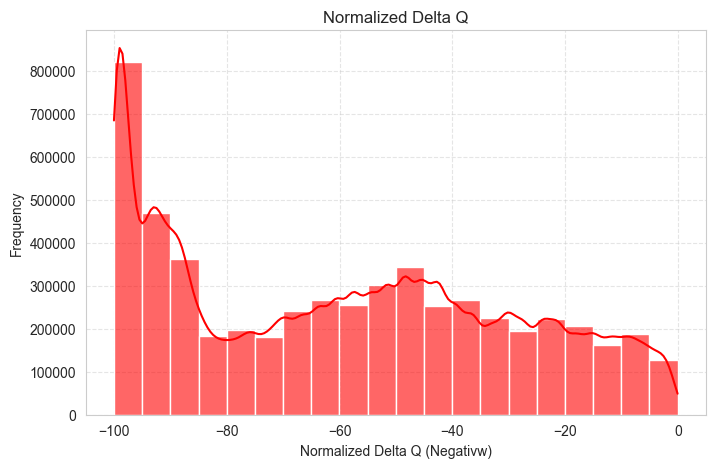

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# 负数分布的直方图
plt.figure(figsize=(8, 5))
sns.histplot(negative_values, kde=True, bins=20, color='red', alpha=0.6)
plt.title('Normalized Delta Q')
plt.xlabel('Normalized Delta Q (Negativw)')
plt.ylabel('Frequency')
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [100]:
df.head()

,well_id,date,wte,gse,gage_id,gage_lat,gage_lon,well_lat,well_lon,wte_meters,reach_elev_m,delta_elev,delta_bin,q,bfd,wte0,q0,delta_wte,delta_q,normalized_delta_q
7253075,410241110523801,2002-09-17,7530.000000,7540.0,10016900,41.270224,-110.963793,41.044670,-110.877954,2295.144000,2300.5,5.356000,5 to 10,26.0,1.0,7530.00,26.0,0.000000,-15.1,0.000000
7253125,410647110503101,2002-09-17,7341.540000,7350.0,10016900,41.270224,-110.963793,41.113003,-110.842676,2237.701392,2224.5,-13.201392,-20 to -10,26.0,1.0,7341.54,26.0,0.000000,0.0,0.000000
7253206,411544110573801,2002-09-17,6745.800000,6770.0,10016900,41.270224,-110.963793,41.262168,-110.960459,2056.119840,2046.0,-10.119840,-20 to -10,26.0,1.0,6745.80,26.0,0.000000,-250.0,0.000000
7253271,411544110573801,2002-09-18,6745.793088,6770.0,10016900,41.270224,-110.963793,41.262168,-110.960459,2056.117733,2046.0,-10.117733,-20 to -10,64.0,1.0,6745.80,26.0,-0.006912,-212.0,146.153846
7253310,410647110503101,2002-09-18,7341.549315,7350.0,10016900,41.270224,-110.963793,41.113003,-110.842676,2237.704231,2224.5,-13.204231,-20 to -10,64.0,1.0,7341.54,26.0,0.009315,38.0,146.153846


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

# 创建输出目录
os.makedirs('base_on_bfd_1', exist_ok=True)

# 拷贝并预处理数据
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['gage_id', 'date'])

# 计算 normalized delta_q = (q - q0)/q0 * 100（按每个 gage 的首个 q）
df['q0'] = df.groupby('gage_id')['q'].transform('first')
# 删除 q0 小于等于 0 的记录
# df = df[df['q0'] > 0]
df['normalized_delta_q'] = df['delta_q'] / df['q0'] * 100  # 单位为 %

# 清理无效数据
df = df.dropna(subset=['delta_wte', 'normalized_delta_q'])

# 创建图形
plt.figure(figsize=(12, 7))

# 统一颜色绘图
plt.scatter(df['delta_wte'], df['normalized_delta_q'], color='blue', alpha=0.5, s=20)

# 拟合所有点的回归线
slope, intercept, r_value, p_value, std_err = linregress(df['delta_wte'], df['normalized_delta_q'])
x_vals = pd.Series(sorted(df['delta_wte'].unique()))
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Linear Fit')

# 构造说明框内容
legend_text = (
    f"Total wells: {df['well_id'].nunique()}\n"
    f"Measurements: {len(df)}\n"
    f"Slope: {slope:.2f} %/ft\n"
    f"R²: {r_value ** 2:.3f}\n"
    f"P-value: {p_value:.4f}"
)

# 添加文字说明框
plt.text(
    0.98, 0.95,
    legend_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    ha='right',
    va='top',
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.7, boxstyle='round,pad=0.4')
)

# 图像设置
plt.title('Normalized ΔQ (% of Q₀) vs ΔWTE — All Gages')
plt.xlabel('ΔWTE (ft)')
plt.ylabel('Normalized ΔQ (%)')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_facecolor('white')

# 保存图像
plt.savefig('base_on_bfd_1/all_gages_normalized_delta_q_vs_delta_wte.png', bbox_inches='tight')
plt.close()


/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/794681162.py:62: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig('base_on_bfd_1/all_gages_normalized_delta_q_vs_delta_wte.png', bbox_inches='tight')


/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/3557682417.py:46: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig('base_on_bfd_1/highlighted_negative_normalized_delta_q_vs_delta_wte.png', bbox_inches='tight')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


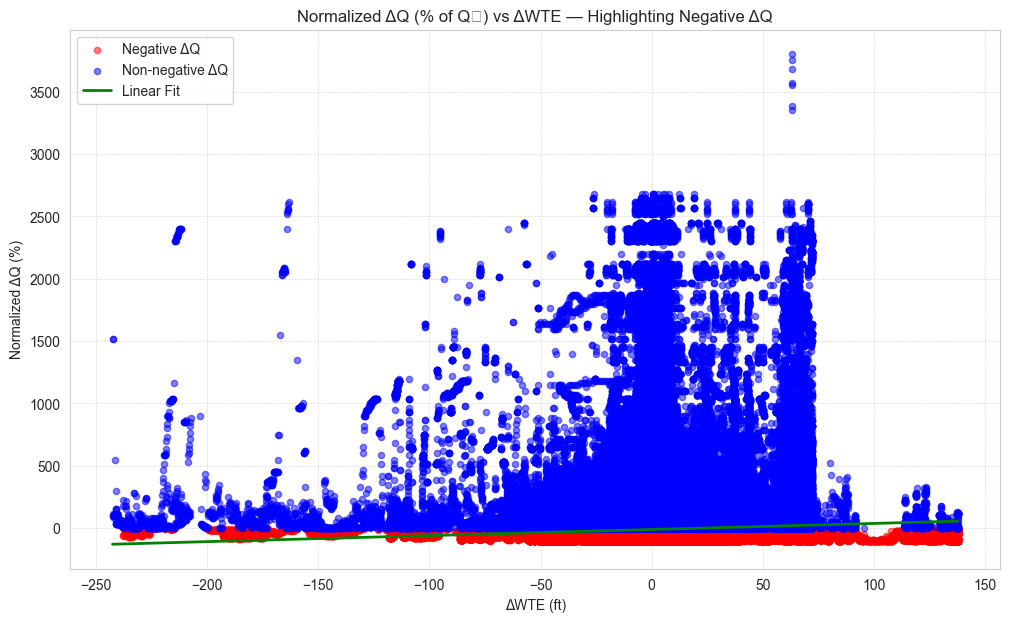

In [86]:
# Highlighting negative values of normalized_delta_q
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

# Ensure the 'df' DataFrame is already prepared, sorted, and cleaned
df_negative = df[df['normalized_delta_q'] < 0]  # Filter negative values
df_positive = df[df['normalized_delta_q'] >= 0]  # Filter non-negative values

# Plot negative and positive values separately
plt.figure(figsize=(12, 7))
plt.scatter(
    df_negative['delta_wte'],
    df_negative['normalized_delta_q'],
    color='red',
    alpha=0.5,
    s=20,
    label='Negative ΔQ'
)
plt.scatter(
    df_positive['delta_wte'],
    df_positive['normalized_delta_q'],
    color='blue',
    alpha=0.5,
    s=20,
    label='Non-negative ΔQ'
)

# Linear regression and plotting for visualization
slope, intercept, r_value, p_value, std_err = linregress(df['delta_wte'], df['normalized_delta_q'])
x_vals = pd.Series(sorted(df['delta_wte'].unique()))
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='green', linewidth=2, label='Linear Fit')

# Adding a legend
plt.legend(loc='upper left')

# Annotation and aesthetics
plt.title('Normalized ΔQ (% of Q₀) vs ΔWTE — Highlighting Negative ΔQ')
plt.xlabel('ΔWTE (ft)')
plt.ylabel('Normalized ΔQ (%)')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_facecolor('white')

# Save or display the figure
plt.savefig('base_on_bfd_1/highlighted_negative_normalized_delta_q_vs_delta_wte.png', bbox_inches='tight')
plt.show()

## 算r平方:one gage to one well

In [87]:
import pandas as pd
from scipy.stats import linregress
import os

# Ensure the plots directory exists
os.makedirs('plots', exist_ok=True)

# Assuming final_result_cleaned is the DataFrame without NaN values in 'q'
# Group by gage_id and well_id
grouped = final_result_cleaned.groupby(['gage_id', 'well_id'])

# Initialize a list to store statistical metrics
stats_list = []

# Iterate over each group
for (gage_id, well_id), group in grouped:
    # Drop NaN values for regression
    group = group.dropna(subset=['delta_wte', 'q'])

    if len(group) < 2 or group['delta_wte'].nunique() == 1:
        # Skip if not enough data points for regression or if all x values are identical
        continue

    # Fit a regression line
    slope, intercept, r_value, p_value, std_err = linregress(group['delta_wte'], group['q'])

    # Collect statistics
    stats_list.append({
        'gage_id': gage_id,
        'well_id': well_id,
        'r_squared': r_value ** 2,
        'gage_lat': group['gage_lat'].iloc[0],
        'gage_lon': group['gage_lon'].iloc[0],
        'well_lat': group['well_lat'].iloc[0],
        'well_lon': group['well_lon'].iloc[0]
    })

# Convert the list of statistics to a DataFrame
stats_df = pd.DataFrame(stats_list)

# Save the statistics to a CSV file
stats_df.to_csv('base_on_bfd_1/gage_well_r_squared_30m.csv', index=False)

# Calculate and print the number of unique gages
num_gages = stats_df['gage_id'].nunique()
print(f"Number of unique gages: {num_gages}")

# Calculate and print the total number of wells
total_wells = stats_df['well_id'].nunique()
print(f"Total number of wells: {total_wells}")

# Calculate and print the number of wells per gage
wells_per_gage = stats_df.groupby('gage_id')['well_id'].nunique()
print("Number of wells per gage:")
print(wells_per_gage)


Number of unique gages: 42
Total number of wells: 1443
Number of wells per gage:
gage_id
10016900      2
10020100      7
10020300      7
10026500      2
10028500     15
10038000     19
10039500     18
10046500     18
10068500     35
10079500     58
10092700     92
10102250    117
10106000      1
10118000    237
10125500     34
10126000    293
10128500      1
10129300      6
10129500     29
10130500     54
10131000      1
10132000     40
10133600      7
10133650      1
10133800      1
10134500     48
10136500    142
10140100      5
10141000    305
10146000      1
10146400     61
10150500      6
10152000    636
10155000     30
10155200      2
10155500     55
10156000      3
10159500     88
10163000    114
10167000    668
10168000     29
10171000     27
Name: well_id, dtype: int64


In [88]:
stats_df.head()

,gage_id,well_id,r_squared,gage_lat,gage_lon,well_lat,well_lon
0,10016900,410647110503101,0.070738,41.270224,-110.963793,41.113003,-110.842676
1,10016900,411544110573801,0.070738,41.270224,-110.963793,41.262168,-110.960459
2,10020100,410647110503101,0.068670,41.434390,-111.017686,41.113003,-110.842676
3,10020100,411400111000801,0.059521,41.434390,-111.017686,41.233279,-111.002405
4,10020100,411544110573801,0.068670,41.434390,-111.017686,41.262168,-110.960459


# load data for spatial visualization

In [89]:
# Import necessary libraries
import geopandas as gpd

# Define file paths
subbasin_shapefile = 'shp/clipped_703_catchments.shp'
basin_shapefile = 'shp/gsl_basin.shp'
stream_shapefile = 'shp/gsl_stream.shp'
well_shapefile = 'shp/well_shp.shp'

# Read the shapefiles using geopandas
subbasin_gdf = gpd.read_file(subbasin_shapefile)
basin_gdf = gpd.read_file(basin_shapefile)
stream_gdf = gpd.read_file(stream_shapefile)
well_gdf = gpd.read_file(well_shapefile)

# Display the first few rows of each GeoDataFrame
print("Subbasin GeoDataFrame:")
print(subbasin_gdf.info())

print("\nBasin GeoDataFrame:")
print(basin_gdf.info())

print("\nStream GeoDataFrame:")
print(stream_gdf.info())

print("\nWell GeoDataFrame:")
print(well_gdf.info())


Subbasin GeoDataFrame:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6157 entries, 0 to 6156
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ogc_fid   6157 non-null   float64 
 1   linkno    6157 non-null   float64 
 2   geometry  6157 non-null   geometry
dtypes: float64(2), geometry(1)
memory usage: 144.4 KB
None

Basin GeoDataFrame:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OBJECTID_1  1 non-null      int64         
 1   OBJECTID_2  1 non-null      int64         
 2   NAME        1 non-null      object        
 3   BASIN       1 non-null      object        
 4   sqmi        1 non-null      float64       
 5   Acres       1 non-null      float64       
 6   AllReports  1 non-null      object        
 7   FullRept99  1 non-null      object  

In [90]:
upstream_basins = pd.read_csv('data/gage_upstreamcatchments_remove_nan.csv')
print("\nupstream_basins DataFrame:")
upstream_basins.info()


upstream_basins DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10341 entries, 0 to 10340
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gage_id                10341 non-null  int64  
 1   gage_longitude         10341 non-null  float64
 2   gage_latitude          10341 non-null  float64
 3   catchment_id           10341 non-null  float64
 4   catchment_area         10341 non-null  float64
 5   upstream_catchment_id  10338 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 484.9 KB


## 画地图。实验

In [91]:
gage_well_mapping=pd.read_csv('data/gage_well_mapping_revised.csv')
print("\ngage_well_mapping DataFrame:")
gage_well_mapping.info()


gage_well_mapping DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13984 entries, 0 to 13983
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gage_id     13984 non-null  int64  
 1   well_id     13984 non-null  float64
 2   latitude    13984 non-null  float64
 3   longitude   13984 non-null  float64
 4   name        13984 non-null  object 
 5   River       13984 non-null  object 
 6   state       13984 non-null  object 
 7   Well_Name   13984 non-null  object 
 8   lat_dec     13984 non-null  float64
 9   long_dec    13984 non-null  float64
 10  Aquifer_Na  13984 non-null  object 
 11  State       13984 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 1.3+ MB


In [92]:
gage_well_r_square = pd.read_csv('base_on_bfd_1/gage_well_r_squared_30m.csv')

In [93]:
gage_well_r_square.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3315 entries, 0 to 3314
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gage_id    3315 non-null   int64  
 1   well_id    3315 non-null   int64  
 2   r_squared  3315 non-null   float64
 3   gage_lat   3315 non-null   float64
 4   gage_lon   3315 non-null   float64
 5   well_lat   3315 non-null   float64
 6   well_lon   3315 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 181.4 KB


In [94]:
stream_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6717 entries, 0 to 6716
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         6717 non-null   float64 
 1   LINKNO      6717 non-null   float64 
 2   DSLINKNO    6717 non-null   float64 
 3   strmOrder   6717 non-null   float64 
 4   USContArea  6717 non-null   float64 
 5   DSContArea  6717 non-null   float64 
 6   TDXHydroRe  6717 non-null   object  
 7   VPUCode     6717 non-null   float64 
 8   Topologica  6717 non-null   float64 
 9   LengthGeod  6717 non-null   float64 
 10  TerminalLi  6717 non-null   float64 
 11  musk_k      6717 non-null   float64 
 12  musk_x      6717 non-null   float64 
 13  geometry    6717 non-null   geometry
dtypes: float64(12), geometry(1), object(1)
memory usage: 734.8+ KB


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/382562237.py:94: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/382562237.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


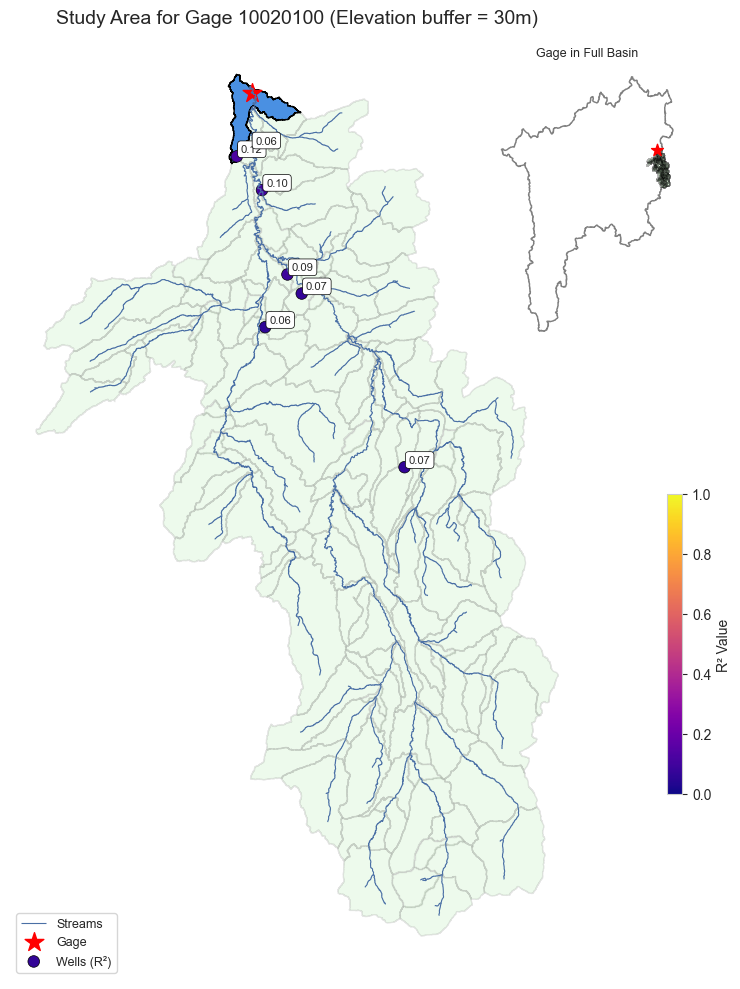

In [95]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from shapely.geometry import Point

# Load data
subbasin_gdf = gpd.read_file('shp/clipped_703_catchments.shp').to_crs("EPSG:4326")
basin_gdf = gpd.read_file('shp/gsl_basin.shp').to_crs("EPSG:4326")
stream_gdf = gpd.read_file('shp/gsl_stream.shp').to_crs("EPSG:4326")
upstream_basins = pd.read_csv('data/gage_upstreamcatchments_remove_nan.csv')
# gage_well_r_square = pd.read_csv('data/gage_well_r_square.csv')

# Global R² range for consistent colorbar
global_min_r2 = gage_well_r_square['r_squared'].min()
global_max_r2 = gage_well_r_square['r_squared'].max()

# Define gage ID
gage_id = 10020100

# Get gage and subbasin info
gage_row = upstream_basins[upstream_basins['gage_id'] == gage_id].iloc[0]
gage_point = Point(gage_row['gage_longitude'], gage_row['gage_latitude'])

main_subbasin_id = gage_row['catchment_id']
main_subbasin = subbasin_gdf[subbasin_gdf['linkno'] == main_subbasin_id]

upstream_ids = upstream_basins[upstream_basins['gage_id'] == gage_id]['upstream_catchment_id'].dropna()
upstream_subbasins = subbasin_gdf[subbasin_gdf['linkno'].isin(upstream_ids)]

# Combine all relevant subbasins (main + upstream)
all_subbasins = pd.concat([main_subbasin, upstream_subbasins])

# Clip streams to these subbasins only
streams_in_subs = gpd.overlay(stream_gdf, all_subbasins, how='intersection')

# Wells for this gage
well_r = gage_well_r_square[gage_well_r_square['gage_id'] == gage_id]
well_r_gdf = gpd.GeoDataFrame(
    well_r,
    geometry=gpd.points_from_xy(well_r['well_lon'], well_r['well_lat']),
    crs="EPSG:4326"
)

# Gage point
gage_geom = gpd.GeoSeries([gage_point], crs="EPSG:4326")

# Start plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot subbasins
upstream_subbasins.plot(ax=ax, color='#A8E6A1', edgecolor='grey', alpha=0.2, label='Upstream Subbasins')
main_subbasin.plot(ax=ax, color='#4A90E2', edgecolor='black', label='Main Subbasin')

# Plot clipped streams
streams_in_subs.plot(ax=ax, color='#4A6FA5', linewidth=0.8, label='Streams')

# Gage point
gage_geom.plot(ax=ax, color='red', marker='*', markersize=200, label='Gage')

# Wells with R²
scatter = ax.scatter(
    well_r_gdf.geometry.x,
    well_r_gdf.geometry.y,
    c=well_r_gdf['r_squared'],
    cmap='plasma',
    edgecolor='black',
    linewidth=0.5,
    s=70,
    vmin=global_min_r2,
    vmax=global_max_r2,
    label='Wells (R²)'
)

# Annotate R²
for _, row in well_r_gdf.iterrows():
    ax.annotate(
        f"{row['r_squared']:.2f}",
        xy=(row.geometry.x, row.geometry.y),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
    )

# Vertical colorbar (bottom right)
cax = fig.add_axes([0.87, 0.2, 0.015, 0.3])  # [left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=global_min_r2, vmax=global_max_r2)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='plasma'), cax=cax, orientation='vertical')
cb.set_label('R² Value', fontsize=10)

# Title and legend
ax.set_title(f"Study Area for Gage {gage_id} (Elevation buffer = 30m)", fontsize=14)
ax.legend(loc='lower left', fontsize=9)
ax.set_axis_off()

# Inset map (top right)
inset_ax = fig.add_axes([0.65, 0.65, 0.28, 0.28])
basin_gdf.plot(ax=inset_ax, color='white', edgecolor='gray')
upstream_subbasins.plot(ax=inset_ax, color='#A8E6A1', edgecolor='black', alpha=0.3)
main_subbasin.plot(ax=inset_ax, color='#4A90E2', edgecolor='black')
gage_geom.plot(ax=inset_ax, color='red', marker='*', markersize=80)
inset_ax.set_title("Gage in Full Basin", fontsize=9)
inset_ax.set_axis_off()

plt.tight_layout()
plt.show()


## 批量画所有well的图

In [ ]:
# Start plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot subbasins with a thicker outline for the main subbasin
upstream_subbasins.plot(ax=ax, color='#A8E6A1', edgecolor='grey', alpha=0.2, label='Upstream Subbasins')
main_subbasin.plot(ax=ax, color='#4A90E2', edgecolor='black', linewidth=2, label='Main Subbasin')  # Thicker outline

# Plot clipped streams with a darker blue color
streams_in_subs.plot(ax=ax, color='#4682B4', linewidth=0.8, label='Streams')

# Wells with R² using an inverted bright colormap and adding a border
scatter = ax.scatter(
    well_r_gdf.geometry.x,
    well_r_gdf.geometry.y,
    c=well_r_gdf['r_squared'],
    cmap='viridis_r',  # Inverted bright colormap
    edgecolor='black',  # Border for each well
    linewidth=0.7,
    s=70,
    vmin=global_min_r2,
    vmax=global_max_r2,
    label='Wells (R²)'
)

# Gage point, ensuring it is plotted on top
gage_geom.plot(ax=ax, color='red', marker='*', markersize=200, zorder=3, label='Gage')

# Annotate R²
for _, row in well_r_gdf.iterrows():
    ax.annotate(
        f"{row['r_squared']:.2f}",
        xy=(row.geometry.x, row.geometry.y),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
    )

# Add annotations for R-squared range, max, min, and number of wells
r_squared_min = well_r_gdf['r_squared'].min()
r_squared_max = well_r_gdf['r_squared'].max()
num_wells = well_r_gdf.shape[0]

ax.text(0.05, 0.95, f'R² Range: {r_squared_min:.2f} - {r_squared_max:.2f}\n'
                    f'Max R²: {r_squared_max:.2f}\n'
                    f'Min R²: {r_squared_min:.2f}\n'
                    f'Number of Wells: {num_wells}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))

# Vertical colorbar (bottom right)
cax = fig.add_axes([0.87, 0.2, 0.015, 0.3])  # [left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=global_min_r2, vmax=global_max_r2)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r'), cax=cax, orientation='vertical')  # Inverted colormap
cb.set_label('R² Value', fontsize=10)

# Title and legend
ax.set_title(f"Study Area for Gage {gage_id} (Elevation buffer = 30m)", fontsize=14)
ax.legend(loc='lower left', fontsize=9)
ax.set_axis_off()

# Inset map (top right)
inset_ax = fig.add_axes([0.65, 0.65, 0.28, 0.28])
basin_gdf.plot(ax=inset_ax, color='white', edgecolor='gray')
upstream_subbasins.plot(ax=inset_ax, color='#A8E6A1', edgecolor='black', alpha=0.3)
main_subbasin.plot(ax=inset_ax, color='#4A90E2', edgecolor='black')
gage_geom.plot(ax=inset_ax, color='red', marker='*', markersize=80)
inset_ax.set_title("Gage in Full Basin", fontsize=9)
inset_ax.set_axis_off()

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Ensure the plots directory exists
os.makedirs('base_on_bfd_1/all_wells_r_square_30m', exist_ok=True)

# Define a list of gage IDs to process
gage_ids = upstream_basins['gage_id'].unique()

# Start processing each gage
for gage_id in gage_ids:
    try:
        # Get gage and subbasin info
        gage_row = upstream_basins[upstream_basins['gage_id'] == gage_id].iloc[0]
        gage_point = Point(gage_row['gage_longitude'], gage_row['gage_latitude'])

        main_subbasin_id = gage_row['catchment_id']
        main_subbasin = subbasin_gdf[subbasin_gdf['linkno'] == main_subbasin_id]

        upstream_ids = upstream_basins[upstream_basins['gage_id'] == gage_id]['upstream_catchment_id'].dropna()
        upstream_subbasins = subbasin_gdf[subbasin_gdf['linkno'].isin(upstream_ids)]

        # Check if the data is empty
        if main_subbasin.empty or upstream_subbasins.empty:
            print(f"Skipping gage {gage_id} due to empty subbasin data.")
            continue

        # Combine all relevant subbasins (main + upstream)
        all_subbasins = pd.concat([main_subbasin, upstream_subbasins])

        # Clip streams to these subbasins only
        streams_in_subs = gpd.overlay(stream_gdf, all_subbasins, how='intersection')

        # Wells for this gage
        well_r = gage_well_r_square[gage_well_r_square['gage_id'] == gage_id]
        well_r_gdf = gpd.GeoDataFrame(
            well_r,
            geometry=gpd.points_from_xy(well_r['well_lon'], well_r['well_lat']),
            crs="EPSG:4326"
        )

        # Check if well data is empty
        if well_r_gdf.empty:
            print(f"Skipping gage {gage_id} due to empty well data.")
            continue

        # Gage point
        gage_geom = gpd.GeoSeries([gage_point], crs="EPSG:4326")

        # Start plotting
        fig, ax = plt.subplots(figsize=(10, 10))

        # Plot subbasins with a thicker outline for the main subbasin
        upstream_subbasins.plot(ax=ax, color='#A8E6A1', edgecolor='grey', alpha=0.2, label='Upstream Subbasins')
        main_subbasin.plot(ax=ax, color='#4A90E2', edgecolor='black', linewidth=2, label='Main Subbasin')  # Thicker outline

        # Plot clipped streams with a darker blue color
        streams_in_subs.plot(ax=ax, color='#4682B4', linewidth=0.8, label='Streams')

        # Wells with R² using an inverted bright colormap and adding a border
        scatter = ax.scatter(
            well_r_gdf.geometry.x,
            well_r_gdf.geometry.y,
            c=well_r_gdf['r_squared'],
            cmap='viridis_r',  # Inverted bright colormap
            edgecolor='black',  # Border for each well
            linewidth=0.5,
            s=70,
            vmin=global_min_r2,
            vmax=global_max_r2,
            label='Wells (R²)'
        )

        # Gage point, ensuring it is plotted on top
        gage_geom.plot(ax=ax, color='red', marker='*', markersize=200, zorder=3, label='Gage')

        # Annotate R²
        for _, row in well_r_gdf.iterrows():
            ax.annotate(
                f"{row['r_squared']:.2f}",
                xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3),
                textcoords='offset points',
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
            )

        # Add annotations for R-squared range, max, min, and number of wells
        r_squared_min = well_r_gdf['r_squared'].min()
        r_squared_max = well_r_gdf['r_squared'].max()
        num_wells = well_r_gdf.shape[0]

        ax.text(0.05, 0.95, f'R² Range: {r_squared_min:.2f} - {r_squared_max:.2f}\n'
                            f'Max R²: {r_squared_max:.2f}\n'
                            f'Min R²: {r_squared_min:.2f}\n'
                            f'Number of Wells: {num_wells}',
                transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))

        # Vertical colorbar (bottom right)
        cax = fig.add_axes([0.87, 0.2, 0.015, 0.3])  # [left, bottom, width, height]
        norm = mpl.colors.Normalize(vmin=global_min_r2, vmax=global_max_r2)
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r'), cax=cax, orientation='vertical')  # Inverted colormap
        cb.set_label('R² Value', fontsize=10)

        # Title and legend
        ax.set_title(f"Study Area for Gage {gage_id} (Elevation buffer = 30m)", fontsize=14)
        ax.legend(loc='lower left', fontsize=9)
        ax.set_axis_off()

        # Inset map (top right)
        inset_ax = fig.add_axes([0.65, 0.65, 0.28, 0.28])
        basin_gdf.plot(ax=inset_ax, color='white', edgecolor='gray')
        upstream_subbasins.plot(ax=inset_ax, color='#A8E6A1', edgecolor='black', alpha=0.3)
        main_subbasin.plot(ax=inset_ax, color='#4A90E2', edgecolor='black')
        gage_geom.plot(ax=inset_ax, color='red', marker='*', markersize=80)
        inset_ax.set_title("Gage in Full Basin", fontsize=9)
        inset_ax.set_axis_off()

        plt.tight_layout()

        # Save the plot to the all_wells_r_square directory
        plt.savefig(f'base_on_bfd_1/all_wells_r_square_30m/gage_{gage_id}.png')
        plt.close()

    except Exception as e:
        print(f"Error processing gage {gage_id}: {e}")


## top 5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 257 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/799341747.py:119: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/799341747.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


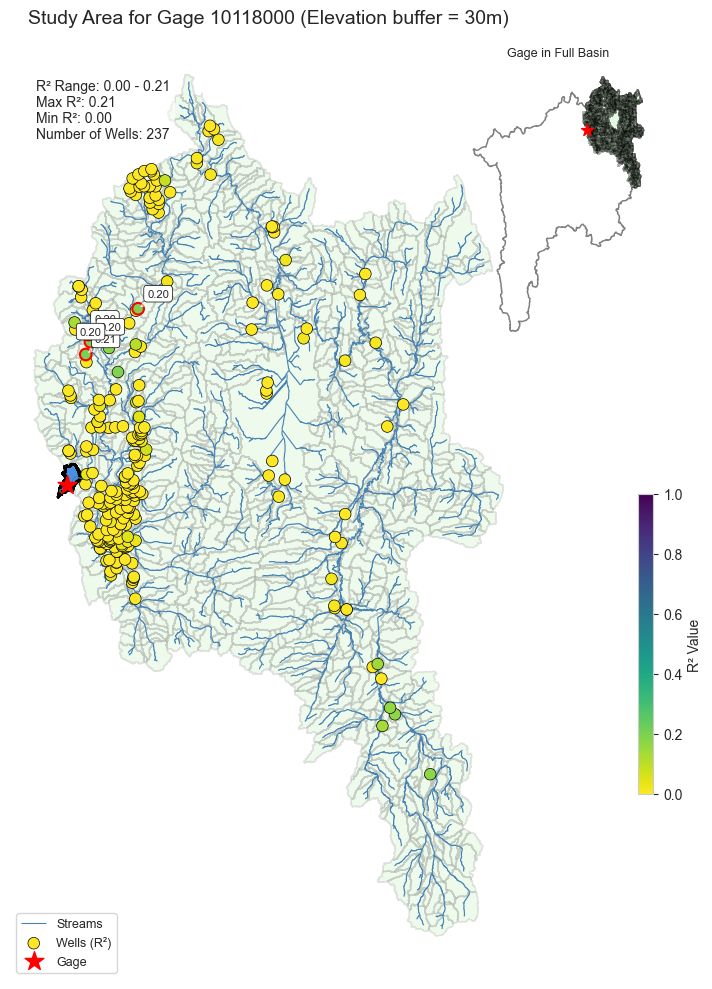

In [96]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Ensure the plots directory exists
os.makedirs('base_on_bfd_1/top_5_r_square_30m', exist_ok=True)

# Select the specific gage ID for demonstration
gage_id = 10118000

# Get gage and subbasin info
gage_row = upstream_basins[upstream_basins['gage_id'] == gage_id].iloc[0]
gage_point = Point(gage_row['gage_longitude'], gage_row['gage_latitude'])

main_subbasin_id = gage_row['catchment_id']
main_subbasin = subbasin_gdf[subbasin_gdf['linkno'] == main_subbasin_id]

upstream_ids = upstream_basins[upstream_basins['gage_id'] == gage_id]['upstream_catchment_id'].dropna()
upstream_subbasins = subbasin_gdf[subbasin_gdf['linkno'].isin(upstream_ids)]

# Combine all relevant subbasins (main + upstream)
all_subbasins = pd.concat([main_subbasin, upstream_subbasins])

# Clip streams to these subbasins only
streams_in_subs = gpd.overlay(stream_gdf, all_subbasins, how='intersection')

# Wells for this gage
well_r = gage_well_r_square[gage_well_r_square['gage_id'] == gage_id]
well_r_gdf = gpd.GeoDataFrame(
    well_r,
    geometry=gpd.points_from_xy(well_r['well_lon'], well_r['well_lat']),
    crs="EPSG:4326"
)

# Gage point
gage_geom = gpd.GeoSeries([gage_point], crs="EPSG:4326")

# Start plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot subbasins with a thicker outline for the main subbasin
upstream_subbasins.plot(ax=ax, color='#A8E6A1', edgecolor='grey', alpha=0.2, label='Upstream Subbasins')
main_subbasin.plot(ax=ax, color='#4A90E2', edgecolor='black', linewidth=2, label='Main Subbasin')  # Thicker outline

# Plot clipped streams with a darker blue color
streams_in_subs.plot(ax=ax, color='#4682B4', linewidth=0.8, label='Streams')

# Plot all wells with a standard border
ax.scatter(
    well_r_gdf.geometry.x,
    well_r_gdf.geometry.y,
    c=well_r_gdf['r_squared'],
    cmap='viridis_r',  # Inverted bright colormap
    edgecolor='black',  # Standard border for all wells
    linewidth=0.5,
    s=70,
    vmin=global_min_r2,
    vmax=global_max_r2,
    zorder=3,  # Ensure wells are on top of other map layers
    label='Wells (R²)'
)

# Highlight top 5 wells with a red border
top_5_wells = well_r_gdf.nlargest(5, 'r_squared')
ax.scatter(
    top_5_wells.geometry.x,
    top_5_wells.geometry.y,
    c=top_5_wells['r_squared'],
    cmap='viridis_r',
    edgecolor='red',  # Red border for top 5 wells
    linewidth=1.5,
    s=70,
    vmin=global_min_r2,
    vmax=global_max_r2,
    zorder=4  # Ensure top 5 wells are above other wells
)

# Gage point, ensuring it is plotted on top
gage_geom.plot(ax=ax, color='red', marker='*', markersize=200, zorder=5, label='Gage')

# Annotate top 5 R² with arrows pointing to wells, placing annotations outside the combined basin boundary
for i, row in enumerate(top_5_wells.itertuples()):
    # Calculate offset for the annotation
    offset_x = 0.03 if i % 2 == 0 else -0.03
    offset_y = 0.03 if i % 2 == 0 else -0.0

    ax.annotate(
        f"{row.r_squared:.2f}",
        xy=(row.geometry.x, row.geometry.y),
        xytext=(row.geometry.x + offset_x, row.geometry.y + offset_y),  # Offset the text outside the combined basin
        textcoords='data',
        fontsize=8,
        arrowprops=dict(facecolor='red', arrowstyle='->', lw=0.5),
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5),
        zorder=6  # Ensure annotations are on top
    )

# Add annotations for R-squared range, max, min, and number of wells
r_squared_min = well_r_gdf['r_squared'].min()
r_squared_max = well_r_gdf['r_squared'].max()
num_wells = well_r_gdf.shape[0]

ax.text(0.05, 0.95, f'R² Range: {r_squared_min:.2f} - {r_squared_max:.2f}\n'
                    f'Max R²: {r_squared_max:.2f}\n'
                    f'Min R²: {r_squared_min:.2f}\n'
                    f'Number of Wells: {num_wells}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))

# Vertical colorbar (bottom right)
cax = fig.add_axes([0.87, 0.2, 0.015, 0.3])  # [left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=global_min_r2, vmax=global_max_r2)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r'), cax=cax, orientation='vertical')  # Inverted colormap
cb.set_label('R² Value', fontsize=10)

# Title and legend
ax.set_title(f"Study Area for Gage {gage_id} (Elevation buffer = 30m)", fontsize=14)
ax.legend(loc='lower left', fontsize=9)
ax.set_axis_off()

# Inset map (top right)
inset_ax = fig.add_axes([0.65, 0.65, 0.28, 0.28])
basin_gdf.plot(ax=inset_ax, color='white', edgecolor='gray')
upstream_subbasins.plot(ax=inset_ax, color='#A8E6A1', edgecolor='black', alpha=0.3)
main_subbasin.plot(ax=inset_ax, color='#4A90E2', edgecolor='black')
gage_geom.plot(ax=inset_ax, color='red', marker='*', markersize=80)
inset_ax.set_title("Gage in Full Basin", fontsize=9)
inset_ax.set_axis_off()

plt.tight_layout()
plt.show()


In [97]:
pip install adjustText


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [98]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl
import pandas as pd
from shapely.geometry import Point

# Ensure the plots directory exists
os.makedirs('base_on_bfd_1/top_5_r_square_30m', exist_ok=True)

# Iterate over each unique gage_id
for gage_id in upstream_basins['gage_id'].unique():
    try:
        # Get gage and subbasin info
        gage_row = upstream_basins[upstream_basins['gage_id'] == gage_id].iloc[0]
        gage_point = Point(gage_row['gage_longitude'], gage_row['gage_latitude'])

        main_subbasin_id = gage_row['catchment_id']
        main_subbasin = subbasin_gdf[subbasin_gdf['linkno'] == main_subbasin_id]

        upstream_ids = upstream_basins[upstream_basins['gage_id'] == gage_id]['upstream_catchment_id'].dropna()
        upstream_subbasins = subbasin_gdf[subbasin_gdf['linkno'].isin(upstream_ids)]

        # Combine all relevant subbasins (main + upstream)
        all_subbasins = pd.concat([main_subbasin, upstream_subbasins])

        # Clip streams to these subbasins only
        streams_in_subs = gpd.overlay(stream_gdf, all_subbasins, how='intersection')

        # Wells for this gage
        well_r = gage_well_r_square[gage_well_r_square['gage_id'] == gage_id]
        well_r_gdf = gpd.GeoDataFrame(
            well_r,
            geometry=gpd.points_from_xy(well_r['well_lon'], well_r['well_lat']),
            crs="EPSG:4326"
        )

        # Skip if there are no wells for this gage
        if well_r_gdf.empty:
            print(f"Skipping gage {gage_id} due to no well data.")
            continue

        # Gage point
        gage_geom = gpd.GeoSeries([gage_point], crs="EPSG:4326")

        # Calculate the bounding box for all relevant features
        combined_bounds = all_subbasins.total_bounds
        x_min, y_min, x_max, y_max = combined_bounds
        x_range = x_max - x_min
        y_range = y_max - y_min

        # Start plotting
        fig, ax = plt.subplots(figsize=(10, 10))

        # Plot subbasins with a thicker outline for the main subbasin
        upstream_subbasins.plot(ax=ax, color='#A8E6A1', edgecolor='grey', alpha=0.2, label='Upstream Subbasins')
        main_subbasin.plot(ax=ax, color='#4A90E2', edgecolor='black', linewidth=2, label='Main Subbasin')  # Thicker outline

        # Plot clipped streams with a darker blue color
        streams_in_subs.plot(ax=ax, color='#4682B4', linewidth=0.8, label='Streams')

        # Plot all wells with a standard border
        ax.scatter(
            well_r_gdf.geometry.x,
            well_r_gdf.geometry.y,
            c=well_r_gdf['r_squared'],
            cmap='viridis_r',  # Inverted bright colormap
            edgecolor='black',  # Standard border for all wells
            linewidth=0.5,
            s=70,
            vmin=global_min_r2,
            vmax=global_max_r2,
            zorder=3,  # Ensure wells are on top of other map layers
            label='Wells (R²)'
        )
        gage_geom.plot(ax=ax, color='red', marker='*', markersize=200, zorder=5, label='Gage')
        # Highlight top 5 wells with a red border
        top_5_wells = well_r_gdf.nlargest(5, 'r_squared')
        ax.scatter(
            top_5_wells.geometry.x,
            top_5_wells.geometry.y,
            c=top_5_wells['r_squared'],
            cmap='viridis_r',
            edgecolor='orange',  # Red border for top 5 wells
            linewidth=1.5,
            s=70,
            vmin=global_min_r2,
            vmax=global_max_r2,
            zorder=4  # Ensure top 5 wells are above other wells
        )

        # Annotate top 5 R² with straight red arrows pointing to wells
        for i, row in enumerate(top_5_wells.itertuples()):
            well_point = row.geometry

            # Find the nearest point on the basin boundary to this well
            basin_boundary = all_subbasins.unary_union.boundary
            nearest_point = basin_boundary.interpolate(basin_boundary.project(well_point))

            # Calculate direction vector from well to boundary point
            direction_x = nearest_point.x - well_point.x
            direction_y = nearest_point.y - well_point.y

            # Normalize the direction vector
            magnitude = np.sqrt(direction_x**2 + direction_y**2)
            if magnitude > 0:
                normalized_x = direction_x / magnitude
                normalized_y = direction_y / magnitude
            else:
                normalized_x, normalized_y = 1, 0

            # Position for the bubble (outside basin boundary)
            annotation_pos = (
                nearest_point.x + normalized_x * 0.1,
                nearest_point.y + normalized_y * 0.1
            )

            # Straight red arrows from bubbles to wells
            ax.annotate(
                f"R² = {row.r_squared:.2f}",
                xy=(row.geometry.x, row.geometry.y),
                xytext=annotation_pos,
                textcoords='data',
                fontsize=9,
                arrowprops=dict(
                    facecolor='orange',
                    edgecolor='orange',
                    arrowstyle='->',
                    lw=1.5,
                    connectionstyle="arc3,rad=0"
                ),
                bbox=dict(
                    boxstyle="round,pad=0.5",
                    fc="white",
                    ec="orange",
                    lw=1.5
                ),
                zorder=6,
                ha='center',
                va='center'
            )

        # Add annotations for R-squared range, max, min, and number of wells
        r_squared_min = well_r_gdf['r_squared'].min()
        r_squared_max = well_r_gdf['r_squared'].max()
        num_wells = well_r_gdf.shape[0]

        ax.text(0.05, 0.95, f'R² Range: {r_squared_min:.2f} - {r_squared_max:.2f}\n'
                            f'Max R²: {r_squared_max:.2f}\n'
                            f'Min R²: {r_squared_min:.2f}\n'
                            f'Number of Wells: {num_wells}',
                transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))

        # Vertical colorbar (bottom right)
        cax = fig.add_axes([0.87, 0.2, 0.015, 0.3])
        norm = mpl.colors.Normalize(vmin=global_min_r2, vmax=global_max_r2)
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r'), cax=cax, orientation='vertical')
        cb.set_label('R² Value', fontsize=10)

        # Title and legend
        ax.set_title(f"Study Area for Gage {gage_id} (Elevation buffer = 30m)", fontsize=14)
        ax.legend(loc='lower left', fontsize=9)
        ax.set_axis_off()

        # Inset map (top right)
        inset_ax = fig.add_axes([0.65, 0.65, 0.28, 0.28])
        basin_gdf.plot(ax=inset_ax, color='white', edgecolor='gray')
        upstream_subbasins.plot(ax=inset_ax, color='#A8E6A1', edgecolor='black', alpha=0.3)
        main_subbasin.plot(ax=inset_ax, color='#4A90E2', edgecolor='black')
        gage_geom.plot(ax=inset_ax, color='red', marker='*', markersize=80)
        inset_ax.set_title("Gage in Full Basin", fontsize=9)
        inset_ax.set_axis_off()

        # Set the limits to match the basin area with enough padding for annotations
        padding = 0.15  # 15% padding
        ax.set_xlim(x_min - x_range * padding, x_max + x_range * padding)
        ax.set_ylim(y_min - y_range * padding, y_max + y_range * padding)

        plt.tight_layout()
        plt.savefig(f'base_on_bfd_1/top_5_r_square_30m/gage_{gage_id}_r_square_top5.png', dpi=300, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Error processing gage {gage_id}: {e}")

# Output the total number of unique gages
num_gages = upstream_basins['gage_id'].nunique()
print(f"Total number of unique gages: {num_gages}")


Skipping gage 10011200 due to no well data.
Skipping gage 10011500 due to no well data.
Skipping gage 10015700 due to no well data.
Skipping gage 10015900 due to no well data.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000

Skipping gage 10023000 due to no well data.


/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 33 dropped geometries of different geometry types than df1 

Skipping gage 10032000 due to no well data.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 36 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: Use

Skipping gage 10041000 due to no well data.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 56 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: Use

Skipping gage 10047500 due to no well data.
Skipping gage 10058600 due to no well data.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 66 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: Use

Skipping gage 10093000 due to no well data.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 165 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: Us

Skipping gage 10104700 due to no well data.
Skipping gage 10104900 due to no well data.
Skipping gage 10105900 due to no well data.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000

Skipping gage 10109000 due to no well data.
Skipping gage 10109001 due to no well data.
Skipping gage 10113500 due to no well data.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 257 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: Us

Skipping gage 10129900 due to no well data.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 58 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: Use

Skipping gage 10132500 due to no well data.


/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folder

Skipping gage 10133980 due to no well data.


/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 74 dropped geometries of different geometry types than df1 

Skipping gage 10137500 due to no well data.
Skipping gage 10139300 due to no well data.


/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 154 dropped geometries of different geometry types than df1

Skipping gage 10143500 due to no well data.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: User

Skipping gage 10148200 due to no well data.
Skipping gage 10149000 due to no well data.
Skipping gage 10149400 due to no well data.
Skipping gage 10149500 due to no well data.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 22 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: Use

Skipping gage 10153100 due to no well data.
Skipping gage 10153800 due to no well data.
Skipping gage 10154200 due to no well data.


/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.

Skipping gage 10157500 due to no well data.


/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 107 dropped geometries of different geometry types than df1

Skipping gage 10164500 due to no well data.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 519 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: Us

Skipping gage 10168500 due to no well data.


/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  basin_boundary = all_subbasins.unary_union.boundary
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:163: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_19860/2477564649.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Skipping gage 10172700 due to no well data.
Skipping gage 10172860 due to no well data.
Skipping gage 10172952 due to no well data.
Total number of unique gages: 77


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


# 分析spatial的规律

In [ ]:
well_reach=pd.read_csv('data/well_reach.csv')

In [ ]:
well_reach.head()

In [ ]:
well_reach.info()

In [ ]:
gage_well_r_square.info()

In [ ]:
pip install pysal, esda, contextily, sklearn, statsmodels

In [ ]:
pip install pysal.lib

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

# Ensure the directory exists
output_dir = 'r_square_vs_distance_30m'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created: {os.path.abspath(output_dir)}")


# Load the two DataFrames (assuming you already have them)
# gage_well_r_square, well_reach

# Step 1: Merge the two DataFrames on well_id
merged_df = pd.merge(gage_well_r_square,
                     well_reach[['well_id', 'distance_to_stream_m']],
                     on='well_id',
                     how='left')

# Step 2: Analyze correlation for each gage
results = []

for gage_id, group in merged_df.groupby('gage_id'):
    if len(group) < 5:
        continue  # Skip if not enough data

    # Calculate Spearman and Pearson correlations
    spearman_corr, spearman_p = spearmanr(group['distance_to_stream_m'], group['r_squared'])
    pearson_corr, pearson_p = pearsonr(group['distance_to_stream_m'], group['r_squared'])

    results.append({
        'gage_id': gage_id,
        'n_wells': len(group),
        'spearman_r': spearman_corr,
        'spearman_p': spearman_p,
        'pearson_r': pearson_corr,
        'pearson_p': pearson_p
    })

    # Visualization for each gage
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=group, x='distance_to_stream_m', y='r_squared')
    sns.regplot(data=group, x='distance_to_stream_m', y='r_squared', scatter=False, color='red')
    plt.title(f'Gage {gage_id} | r={pearson_corr:.2f}, p={pearson_p:.3f}')
    plt.xlabel('Distance to Stream (m)')
    plt.ylabel('R² between Gage & Well')
    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(output_dir, f'gage_{gage_id}_r_square_vs_distance.png'))
    plt.close()

# Step 3: Summarize results
corr_df = pd.DataFrame(results)
print(corr_df.head())


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 加入距离到stream
df = pd.merge(gage_well_r_square, well_reach[['well_id', 'distance_to_stream_m']], on='well_id', how='left')

# 选择变量
features = df[['r_squared', 'distance_to_stream_m']]
X = StandardScaler().fit_transform(features)

# KMeans 聚类
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# 可视化
plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x='distance_to_stream_m', y='r_squared', hue='cluster', palette='Set1')
plt.title('KMeans Clustering of Wells by R² and Distance')
plt.xlabel('Distance to Stream (m)')
plt.ylabel('R²')
plt.show()


In [ ]:
import geopandas as gpd
from libpysal.weights import KNN
from esda.getisord import G_Local
import matplotlib.pyplot as plt
import contextily as ctx

# 假设你已有 gdf 这个 GeoDataFrame
# 如果没有，补一下这步：
# gdf = gpd.GeoDataFrame(...)

# 计算空间权重（推荐 k=5 保平衡）
w = KNN.from_dataframe(gdf, k=5)

# 计算 Getis-Ord Gi*
gi_star = G_Local(gdf['r_squared'], w)
gdf['GiZ'] = gi_star.Zs
gdf['Gi_p'] = gi_star.p_sim
gdf['hotspot'] = (gdf['GiZ'] > 1.96) & (gdf['Gi_p'] < 0.05)
gdf['coldspot'] = (gdf['GiZ'] < -1.96) & (gdf['Gi_p'] < 0.05)

# 可视化热点图
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='lightgrey', markersize=10)
gdf[gdf['hotspot']].plot(ax=ax, color='red', label='Hotspot', markersize=25)
gdf[gdf['coldspot']].plot(ax=ax, color='blue', label='Coldspot', markersize=25)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.legend()
plt.title("Getis-Ord Gi* Hotspot Analysis (R²)")
plt.show()
